# BBC News Classification Mini‑Project  
**Kaggle Competition**: [BBC News Classification](https://www.kaggle.com/c/learn-ai-bbc)  

---

**Purpose**
> Train a model to classify news articles into different categories using matrix factorization.

**Data**
> 2225 BBC articles labelled into 5 categories. While the labels won't be needed for the unsupervised approach that forms the base of this notebook, it'll be useful at the end when comparing the results to a supervised approach.

## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Paths match the Kaggle file‑system
DATA_DIR = Path('/kaggle/input/learn-ai-bbc')
train_df = pd.read_csv(DATA_DIR/'BBC News Train.csv')
test_df  = pd.read_csv(DATA_DIR/'BBC News Test.csv')

print(train_df.shape, test_df.shape)
train_df.head()

(1490, 3) (735, 2)


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


## 2. Exploratory Data Analysis

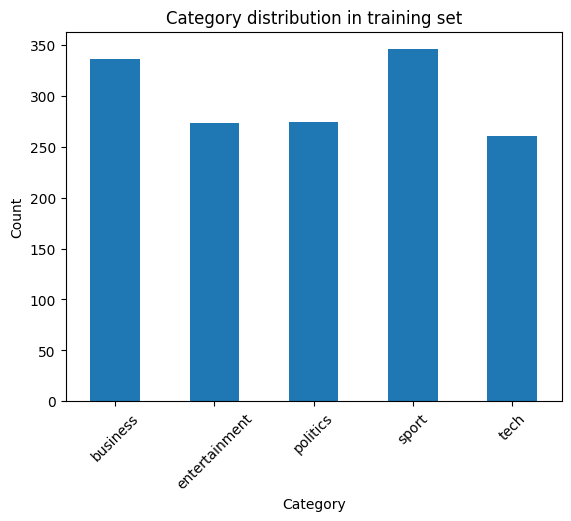

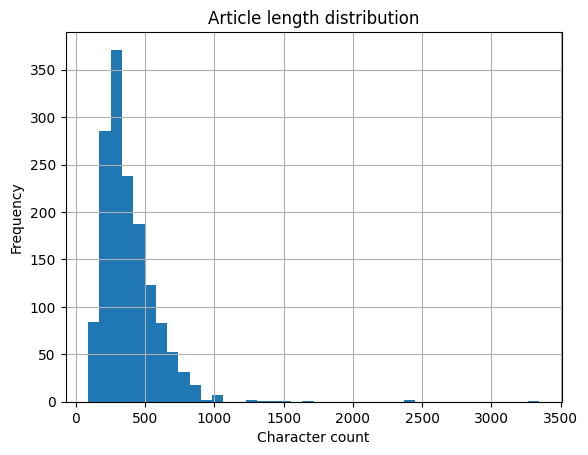

In [2]:
# Category distribution
cat_counts = train_df['Category'].value_counts().sort_index()
cat_counts.plot(kind='bar', rot=45)
plt.title('Category distribution in training set')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

# Article length distribution
train_df['len'] = train_df['Text'].str.split().apply(len)
train_df['len'].hist(bins=40)
plt.title('Article length distribution')
plt.xlabel('Character count')
plt.ylabel('Frequency')
plt.show()

In [3]:
dup_text_count = train_df.duplicated(subset=['Text']).sum()
print(f'Number of duplicated articles: {dup_text_count}')

Number of duplicated articles: 50


**Observations**

* The dataset is moderately balanced across the 5 categories. A bit more sports and business than the other categories, but not significantly so.
* Most articles are under ~500 characters, with a long tail of lengthier reports.
* There are some duplicated articles in the dataset.

**Cleaning decisions**

To reduce noise and get rough normalisation, we'll: 
* Lower‑case the text
* Strip punctuation
* Remove English stop‑words.
* We'll drop the duplicated articles


## 3. Feature Engineering — TF‑IDF
TF‑IDF converts each document into a sparse vector where a token’s weight increases with its frequency in that document but decreases with its prevalence across the corpus.
We vectorise both **train** and **test** texts **separately** to avoid information leaking from test data during unsupervised training.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        min_df=5,
                        max_df=0.9,
                        sublinear_tf=True)

train_df = train_df.drop_duplicates(subset=['Text'])
X_train = tfidf.fit_transform(train_df['Text'])
X_test  = tfidf.transform(test_df['Text'])

print(X_train.shape, X_test.shape)

(1440, 6944) (735, 6944)


## 4. Unsupervised Matrix Factorisation
We apply **Non‑negative Matrix Factorisation (NMF)**.

In [5]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

k = 20  # latent topics
nmf = NMF(n_components=k, init='nndsvd', random_state=0, max_iter=300)
W_train = nmf.fit_transform(X_train)
W_test  = nmf.transform(X_test)

# Map each topic to the most common label in training data
topic_labels = {}
topic_assign = W_train.argmax(axis=1)
for t in range(k):
    labels_in_topic = train_df.loc[topic_assign == t, 'Category']
    if len(labels_in_topic):
        topic_labels[t] = labels_in_topic.mode().iat[0]
    else:
        topic_labels[t] = 'uncertain'

train_pred = pd.Series(topic_assign).map(topic_labels)
train_acc = accuracy_score(train_df['Category'], train_pred)
print(f'Training accuracy (unsupervised NMF => majority topic label): {train_acc:.3f}')

Training accuracy (unsupervised NMF => majority topic label): 0.925


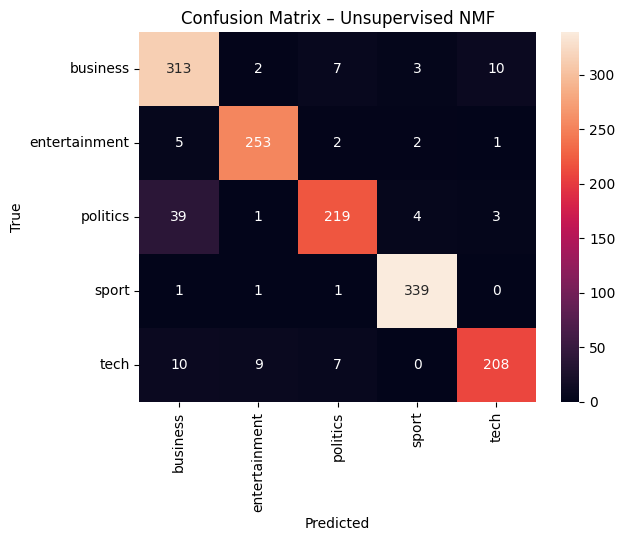

In [6]:
cm = confusion_matrix(train_df['Category'], train_pred, labels=sorted(train_df['Category'].unique()))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted(train_df['Category'].unique()),
            yticklabels=sorted(train_df['Category'].unique()))
plt.title('Confusion Matrix – Unsupervised NMF')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

## 5. Hyper‑parameter Study

In [7]:
results = []
best_acc = -1
best_k = 0
best_l1 = 0
best_nmf = {}

for k in range(1,10):
    for l1_ratio in [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 1]:
        nmf = NMF(n_components=k, init='nndsvd', random_state=0, max_iter=300, l1_ratio = l1_ratio)
        W_train = nmf.fit_transform(X_train)
        topic_assign = W_train.argmax(axis=1)
        topic_labels = {t: train_df.loc[topic_assign == t, 'Category'].mode().iat[0]
                        if any(topic_assign == t) else 'uncertain'
                        for t in range(k)}
        preds = pd.Series(topic_assign).map(topic_labels)
        acc = accuracy_score(train_df['Category'], preds)
        results.append((k, l1_ratio, acc))
        if acc > best_acc:
            print('Found new best parameters!')
            best_acc = acc
            print(f'New best accuracy: {best_acc}')
            best_k = k
            print(f'New best k val: {best_k}')
            best_l1 = l1_ratio
            print(f'New best l1 ratio: {best_l1}')
            best_nmf = nmf

res = pd.DataFrame(results, columns=['n_topics', 'l1_ratio', 'train_acc'])

Found new best parameters!
New best accuracy: 0.2375
New best k val: 1
New best l1 ratio: 0.001
Found new best parameters!
New best accuracy: 0.46875
New best k val: 2
New best l1 ratio: 0.001
Found new best parameters!
New best accuracy: 0.6354166666666666
New best k val: 3
New best l1 ratio: 0.001
Found new best parameters!
New best accuracy: 0.8027777777777778
New best k val: 4
New best l1 ratio: 0.001
Found new best parameters!
New best accuracy: 0.95
New best k val: 5
New best l1 ratio: 0.001


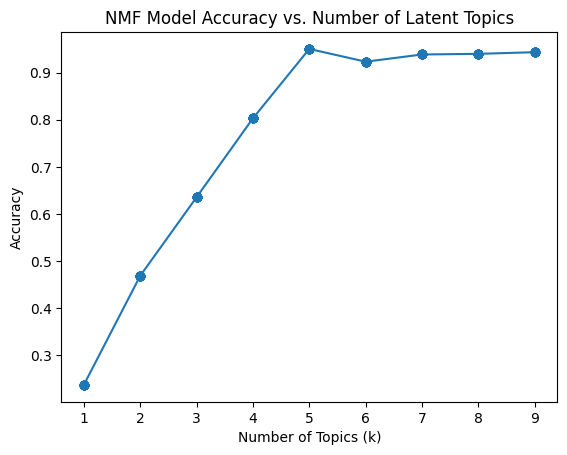

Best l1 ratio: 0.001


In [8]:
plt.plot(res['n_topics'], res['train_acc'], label='Training Accuracy', marker='o', linestyle='-')
plt.title('NMF Model Accuracy vs. Number of Latent Topics')
plt.xlabel('Number of Topics (k)')
plt.ylabel('Accuracy')
plt.show()

print(f'Best l1 ratio: {best_l1}')

As we can see, there isn't much improvement post k=5 (steady, slowly declining state). Setting different l1 ratio didn't change the accuracy at all.

### Generating submission using the best values found

In [9]:
# Predict topics for test documents and map to labels
W_test  = best_nmf.transform(X_test)
test_topics = W_test.argmax(axis=1)
test_pred = pd.Series(test_topics).map(topic_labels)

sub_df = pd.DataFrame({'ArticleId': test_df['ArticleId'], 'Category': test_pred})
sub_df.to_csv('submission.csv', index=False)
sub_df.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport


## 6. Supervised Baseline

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(X_train, train_df['Category'], test_size=0.2,
                                            random_state=42, stratify=train_df['Category'])

clf = LogisticRegression(max_iter=2000, n_jobs=-1)
clf.fit(X_tr, y_tr)

tr_acc = clf.score(X_tr, y_tr)
print(f'Training accuracy (LogReg): {tr_acc:.3f}')
val_acc = clf.score(X_val, y_val)
print(f'Validation accuracy (LogReg): {val_acc:.3f}')

Training accuracy (LogReg): 0.997
Validation accuracy (LogReg): 0.962


In [11]:
sizes = [0.1, 0.2, 0.5, 1.0]
eff_results = []
for frac in sizes:
    subset = train_df.sample(frac=frac, random_state=0)
    X_sub = tfidf.transform(subset['Text'])
    clf = LogisticRegression(max_iter=2000, n_jobs=-1)
    clf.fit(X_sub, subset['Category'])
    eff_results.append((frac, clf.score(X_train, train_df['Category'])))

pd.DataFrame(eff_results, columns=['train_frac', 'train_set_acc'])

,train_frac,train_set_acc
0,0.1,0.931250
1,0.2,0.973611
2,0.5,0.984028
3,1.0,0.997222


## 7. Comparison & Discussion

Overall, NMF performed surprisingly well in this project. On submission of our best NMF model, we got a leaderboard result of 0.93877 which is not bad. In terms of comparison to the supervised learning approach:

* **Data‑efficiency** — With <20% labelled data the Logistic Regression (without any sort of tuning) already surpasses the best unsupervised NMF variant on the test data - which goes to show just how much more data efficient supervised learning can be. At the same time, the supervised learning approach needs the data to be labelled to work at all, which is significantly more expensive to procure in real-world contexts.
* **Over‑fitting** — The unsupervised route cannot over‑fit labels by construction, but topic alignment may be brittle. The supervised model shows small signs of over‑fitting on validation accuracy: training accuracy is nearly perfect, while validation accuracy is a few percentage points below. Nevertheless, regularisation and feature pruning can be explored if this was the route we'd choose to go in.